# Projet 7 : Réalisez des indexations automatiques d’images
# <u>B. Classification des images avec méthodes supervisées</u> <br/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import  KNeighborsClassifier

from glob import glob
import scipy
from skimage.io import imread
from skimage import exposure
from skimage import img_as_ubyte
from skimage.filters import gaussian
import cv2



warnings.filterwarnings("ignore")

In [2]:
print('OpenCV Version',cv2.__version__)

OpenCV Version 3.4.1


# 1. Préparation des données

## 1.1 Configuration des noms de répertoires

In [3]:
DATA_DIR = 'data'
TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'

Les images sont chargées à partir du chemin spécifié.<br/>
Les images doivent être rangés dans un dossier dont le nom contient la race correspondante<br/>
 \- breed<br/>
&nbsp;&nbsp;&nbsp;      \--- image 1 <br/>
&nbsp;&nbsp;&nbsp;      \--- image 2<br/>

## 1.2 Chargement données entrainement et tests

In [4]:
train_df = pd.read_csv(TRAIN_DIR + '/images_infos.csv')
train_df['filepath'] = TRAIN_DIR + '/' + train_df['filepath'].astype(str)
test_df = pd.read_csv(TEST_DIR + '/images_infos.csv')
test_df['filepath'] = TEST_DIR + '/' + test_df['filepath'].astype(str)

In [5]:
display(train_df.head())
print("Train size : " + str(train_df.shape[0]))

,filepath,breed
0,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky
1,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky
2,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky
3,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky
4,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky


Train size : 2000


In [6]:
display(test_df.head())
print("Test size : " + str(test_df.shape[0]))

,filepath,breed
0,data/test/n02110185-Siberian_husky/n02110185_1...,Siberian_husky
1,data/test/n02110185-Siberian_husky/n02110185_9...,Siberian_husky
2,data/test/n02110185-Siberian_husky/n02110185_3...,Siberian_husky
3,data/test/n02110185-Siberian_husky/n02110185_7...,Siberian_husky
4,data/test/n02110185-Siberian_husky/n02110185_1...,Siberian_husky


Test size : 354


## 1.3 Numérisation de la variable race de chien

- Conversion de la donnée race de chien en format numérique pour pouvoir ensuite appliquer nos algorithmes.

In [7]:
lb_breed = LabelEncoder()
train_df['breed_code'] = lb_breed.fit_transform(train_df["breed"])
test_df['breed_code'] = lb_breed.transform(test_df["breed"])
train_df.head()

,filepath,breed,breed_code
0,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky,3
1,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky,3
2,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky,3
3,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky,3
4,data/train/n02110185-Siberian_husky/n02110185_...,Siberian_husky,3


- Décodage du code de la race

In [8]:
'''
Méthode qui retourne le nom de la race associé à la valeur numérique
'''
def decodeLabel(num_label) :
    #warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    l = lb_breed.inverse_transform(num_label)
    #warnings.resetwarnings()
    return l

In [9]:
max_code = max(train_df['breed_code'])
breed_names = decodeLabel(range(max_code+1))
breed_names

array(['Chihuahua', 'Maltese_dog', 'Scotch_terrier', 'Siberian_husky'],
      dtype=object)

# 2. Bag of Visual Words

## 2.1 Extraction SIFT

In [10]:
'''
 Extraction des features pour une liste d'images (format binaire)
'''
def extractFeatures(images) :
    start_time = time()
    descriptor_list = []
    for im in images:
        cv_img = img_as_ubyte(im)
        cv_img = cv2.cvtColor(cv_img, cv2.COLOR_RGB2BGR)
        gray_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, desc = sift.detectAndCompute(gray_img, None)
        descriptor_list.append(desc)
    print("SIFT Extraction elapsed time : %0.2fs."%(time() - start_time))
    return descriptor_list

## 2.2 Images histogrammes (Bag of visual words)

In [11]:
class MyBagOfVisualWords():
    
    def __init__(self, n_cluster, feature_descriptors):
        self.n_cluster = n_cluster
        self.scaler = StandardScaler()
        combined_features = np.vstack(np.array(feature_descriptors))
        self.kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
        self.kmeans.fit(combined_features)
        
    
    def _constructVocabulary(self, feature_descriptors):
        start_time=time()
        combined_features = np.vstack(np.array(feature_descriptors))
        self.vocabulary = self.kmeans.predict(combined_features)
        print("Vocabulary construction elapsed time : %0.2fs."%(time() - start_time))
        return self.vocabulary

 
    def getBagOfVisualWords(self, feature_descriptors) :
        self._constructVocabulary(feature_descriptors)
        start_time = time()
        bovw_hist = np.zeros([len(feature_descriptors), self.n_cluster])
        indice = 0
        for index, features in enumerate(feature_descriptors):
            try:
                l = len(features)
                img_vocab = self.vocabulary[indice:indice + l]
                indice += l
                for i in img_vocab :
                    bovw_hist[index, i] += 1
            except:
                pass
        print("BOVW elapsed time : %0.2fs."%(time() - start_time))
        return bovw_hist     

# 3. Classification - Sélection algorithme

## 3.1 Préparation des données

In [12]:
x_train_img = np.array(train_df['filepath'].apply(imread))
y_train = train_df['breed_code']

In [13]:
x_test_img = np.array(test_df['filepath'].apply(imread))
y_test = test_df['breed_code']

In [14]:
n_clusters = 100

### Extraction SIFT features

In [15]:
x_train_features = extractFeatures(x_train_img)

SIFT Extraction elapsed time : 159.21s.


### Images histogrammes

In [16]:
bovw = MyBagOfVisualWords(n_clusters, x_train_features)
x_train = bovw.getBagOfVisualWords(x_train_features)

Vocabulary construction elapsed time : 9.83s.
BOVW elapsed time : 1.00s.


### Standardisation

In [17]:
scaler = StandardScaler()
x_train= scaler.fit_transform(x_train)

### Test data

In [18]:
x_test_features = extractFeatures(x_test_img)
y_test = test_df['breed_code']

SIFT Extraction elapsed time : 105.33s.


In [19]:
x_test = bovw.getBagOfVisualWords(x_test_features)
x_test= scaler.transform(x_test)

Vocabulary construction elapsed time : 3.36s.
BOVW elapsed time : 0.77s.


## 3.2 Comparaison des algorithmes de classification

In [113]:
'''
Méthode générique pour faire une recherche sur grille et évaluer le modèle de classification.
'''
def evaluateClassifier(classifier, x_train, y_train, x_test, y_test,  folds=5 ,parameters={}) :
    start_time = time()
    clf_CV = GridSearchCV(estimator = classifier, param_grid = parameters, cv = folds, scoring='accuracy', n_jobs=-1)
    clf_CV.fit(x_train, y_train)
    y_pred = clf_CV.predict(x_test)
    print("=> Classification accuracy: {:.2f} % \n".format(100*metrics.accuracy_score(y_test, y_pred)))
    report = classification_report(y_test, y_pred)
    print(report)
    print("Evaluation elapsed time : %0.2fs."%(time() - start_time))
    return clf_CV, y_pred

In [32]:
'''
Affichage de la matrice de confusion
'''
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def displayConfusionMatrix(y_test, y_pred) :
    cnf_matrix = confusion_matrix(y_test, y_pred) 
    np.set_printoptions(precision=2)
    plt.figure(figsize = (4,4))
    plot_confusion_matrix(cnf_matrix, classes=breed_names, normalize = False, title='Confusion matrix')

### Support Vector Machine

=> Classification accuracy: 50.00 % 

             precision    recall  f1-score   support

          0       0.30      0.42      0.35        52
          1       0.76      0.49      0.59       152
          2       0.42      0.71      0.53        58
          3       0.47      0.43      0.45        92

avg / total       0.56      0.50      0.51       354

KMeans elapsed time : 2.95s.
Confusion matrix, without normalization


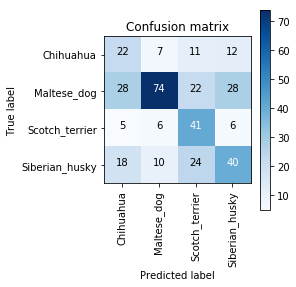

In [170]:
svc  = SVC()
svc_grid, y_pred = evaluateClassifier(svc, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

### Logistic Regression

=> Classification accuracy: 48.31 % 

             precision    recall  f1-score   support

          0       0.30      0.38      0.34        52
          1       0.72      0.52      0.61       152
          2       0.35      0.55      0.43        58
          3       0.45      0.43      0.44        92

avg / total       0.53      0.48      0.50       354

KMeans elapsed time : 1.68s.
Confusion matrix, without normalization


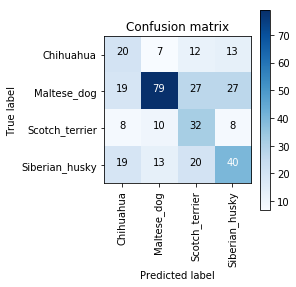

In [117]:
from sklearn.linear_model import LogisticRegression
reg  = LogisticRegression()
reg_grid, y_pred = evaluateClassifier(reg, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

### Arbre de decision

=> Classification accuracy: 29.38 % 

             precision    recall  f1-score   support

          0       0.07      0.12      0.09        52
          1       0.53      0.32      0.40       152
          2       0.22      0.34      0.26        58
          3       0.33      0.33      0.33        92

avg / total       0.36      0.29      0.31       354

KMeans elapsed time : 0.54s.
Confusion matrix, without normalization


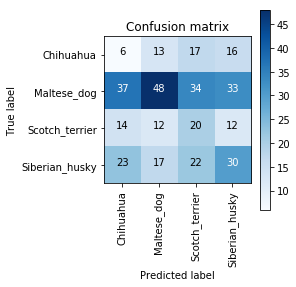

In [118]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree_grid, y_pred = evaluateClassifier(dtree, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

### Gradient Boosting

=> Classification accuracy: 45.20 % 

             precision    recall  f1-score   support

          0       0.26      0.38      0.31        52
          1       0.71      0.47      0.57       152
          2       0.39      0.53      0.45        58
          3       0.39      0.40      0.40        92

avg / total       0.51      0.45      0.47       354

KMeans elapsed time : 14.76s.
Confusion matrix, without normalization


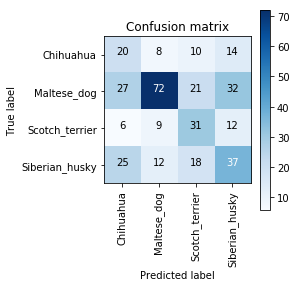

In [119]:
gboost  =  GradientBoostingClassifier()
gboost_grid, y_pred = evaluateClassifier(gboost, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

### Random Forest

=> Classification accuracy: 38.42 % 

             precision    recall  f1-score   support

          0       0.19      0.35      0.25        52
          1       0.70      0.43      0.54       152
          2       0.29      0.41      0.34        58
          3       0.34      0.30      0.32        92

avg / total       0.47      0.38      0.41       354

KMeans elapsed time : 0.53s.
Confusion matrix, without normalization


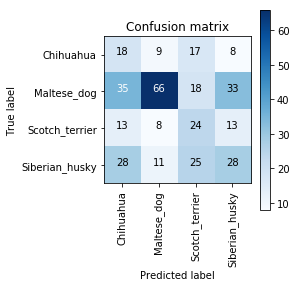

In [120]:
from sklearn.ensemble import RandomForestClassifier
rforest  =  RandomForestClassifier()
rforest_grid, y_pred = evaluateClassifier(rforest, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

### Ada Boost

=> Classification accuracy: 42.09 % 

             precision    recall  f1-score   support

          0       0.26      0.31      0.28        52
          1       0.69      0.47      0.56       152
          2       0.30      0.52      0.38        58
          3       0.36      0.34      0.35        92

avg / total       0.48      0.42      0.43       354

KMeans elapsed time : 1.69s.
Confusion matrix, without normalization


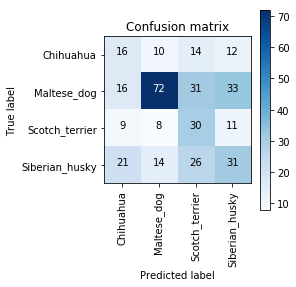

In [121]:
from sklearn.ensemble import AdaBoostClassifier
adaboost  =  AdaBoostClassifier()
adaboost_grid, y_pred = evaluateClassifier(adaboost, x_train, y_train, x_test, y_test)
displayConfusionMatrix(y_test, y_pred)

## 3.3 Résultats

In [122]:
models = { 'Support Vector Machine' : svc_grid, 'Logistic Regression' : reg_grid, 
          'Decision Tree' : dtree_grid, 'Random Forest' : rforest_grid, 'Gradient Boosting' : gboost_grid, 'AdaBoost' : adaboost_grid}
for k, v in models.items() :
    print("{:s} : best score = {:.3f}%".format(k,v.best_score_*100))

Support Vector Machine : best score = 70.400%
Logistic Regression : best score = 59.200%
Decision Tree : best score = 46.750%
Random Forest : best score = 55.900%
Gradient Boosting : best score = 66.250%
AdaBoost : best score = 50.650%


# 4. Tuning avec pré-traitement images

## 4.1 Méthodes pour traitement des images

In [55]:
'''
Equalisation de l'histogramme (Contrast Limited Adaptive Histogram Equalization)
'''
def equalizeHist(img): 
    equ_img = exposure.equalize_hist(img)
    equ_img = img_as_ubyte(equ_img)
    return equ_img

In [56]:
'''
Filtre glaussian blur
'''
def gaussianBlur(img) :
    gauss_img = gaussian(img, sigma=.5, multichannel=True)
    gauss_img = img_as_ubyte(gauss_img)
    return gauss_img

In [57]:
'''
 On essaye de détourer l'image du chienOn essay 
'''
def grabCut(img) :  
    mask = np.zeros(img.shape[:2],np.uint8)
    
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    nb_iter = 2

    rect = (1,1,img.shape[1]-1,img.shape[0]-1)
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,nb_iter,cv2.GC_INIT_WITH_RECT)

    fgd_mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img_grabcut = img_as_ubyte(img*fgd_mask[:,:,np.newaxis])
    return img_grabcut

Quelques méthodes de pré-traitement des images.

In [54]:
'''
Applique les traitements listés dans 'preprocessing' aux images.
'''
def preprocess_images(images_list, preprocessing) :
    start_time = time()
    X_trans=[]
    for im in images_list:
        for p in preprocessing :
            im_trans = im
            if p == 'EqualizeHistogram' :
                im_trans = equalizeHist(im)
            elif p == 'GaussianBlur' :
                im_trans = gaussianBlur(im)
            elif p == 'GrabCut' :
                im_trans = grabCut(im)
            else :
                print("Error unknown processing : ", p)
        X_trans.append(im_trans)
    print("Image Preprocessing elapsed time : %0.2fs."%(time() - start_time))
    return X_trans

In [58]:
def evaluationWithPreprocessing(train_img, y_train, test_img, y_test, preprocessing, n_clusters) :
    #Train
    if len(preprocessing) :
        x_train_img = preprocess_images(train_img, preprocessing)
    else :
        x_train_img = train_img
    img_features = extractFeatures(x_train_img)
    bovw = MyBagOfVisualWords(n_clusters, img_features)
    x_train = bovw.getBagOfVisualWords(img_features)
    scaler = StandardScaler()
    x_train= scaler.fit_transform(x_train)
    
    # Test
    if len(preprocessing) :
        x_test_img = preprocess_images(test_img, preprocessing)
    else :
        x_test_img = test_img
    x_test_features = extractFeatures(x_test_img)
    x_test = bovw.getBagOfVisualWords(x_test_features)
    x_test= scaler.transform(x_test)
    
    svc  = SVC()
    svc_grid, y_pred = evaluateClassifier(svc, x_train, y_train, x_test, y_test)

## 4.2 Egalisation de l'histogramme

In [33]:
evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test, ['EqualizeHistogram'], n_clusters) 

Image Preprocessing elapsed time : 57.88s.
SIFT Extraction elapsed time : 139.14s.
Vocabulary construction elapsed time : 18.26s.
BOVW elapsed time : 1.73s.
Image Preprocessing elapsed time : 14.51s.
SIFT Extraction elapsed time : 43.52s.
Vocabulary construction elapsed time : 2.75s.
BOVW elapsed time : 0.33s.
=> Classification accuracy: 41.81 % 

             precision    recall  f1-score   support

          0       0.25      0.44      0.32        52
          1       0.68      0.38      0.49       152
          2       0.40      0.59      0.48        58
          3       0.36      0.36      0.36        92

avg / total       0.49      0.42      0.43       354

KMeans elapsed time : 3.40s.


## 4.3 Filtre gaussien

In [34]:
evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test,  ['GaussianBlur'], n_clusters) 

Image Preprocessing elapsed time : 38.78s.
SIFT Extraction elapsed time : 118.20s.
Vocabulary construction elapsed time : 7.74s.
BOVW elapsed time : 0.94s.
Image Preprocessing elapsed time : 11.36s.
SIFT Extraction elapsed time : 41.53s.
Vocabulary construction elapsed time : 2.14s.
BOVW elapsed time : 0.33s.
=> Classification accuracy: 48.59 % 

             precision    recall  f1-score   support

          0       0.31      0.46      0.37        52
          1       0.76      0.47      0.58       152
          2       0.40      0.62      0.49        58
          3       0.43      0.45      0.44        92

avg / total       0.55      0.49      0.50       354

KMeans elapsed time : 3.46s.


## 4.4 Grab Cut - suppression arrière plan

In [ ]:
# Met trop de temps ...

In [64]:
#evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test,  ['GrabCut'], n_clusters) 

## 4.5 Résultats

Le filtre gaussien donne le meilleur score. 

# 5. Tuning du nombre de clusters

## 5.1 Avec filtre gaussien

In [65]:
clusters_tuning = [100, 300, 500, 1000]
for k in clusters_tuning :
    print("\n#### Evaluation with number of clusters :", k)
    evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test,  ['GaussianBlur'], k) 


#### Evaluation with number of clusters : 100
Image Preprocessing elapsed time : 44.54s.
SIFT Extraction elapsed time : 183.15s.
Vocabulary construction elapsed time : 18.74s.
BOVW elapsed time : 1.21s.
Image Preprocessing elapsed time : 17.56s.
SIFT Extraction elapsed time : 73.90s.
Vocabulary construction elapsed time : 3.02s.
BOVW elapsed time : 0.30s.
=> Classification accuracy: 48.59 % 

             precision    recall  f1-score   support

          0       0.31      0.46      0.37        52
          1       0.76      0.47      0.58       152
          2       0.40      0.62      0.49        58
          3       0.43      0.45      0.44        92

avg / total       0.55      0.49      0.50       354

KMeans elapsed time : 3.91s.

#### Evaluation with number of clusters : 300
Image Preprocessing elapsed time : 51.46s.
SIFT Extraction elapsed time : 158.19s.
Vocabulary construction elapsed time : 10.37s.
BOVW elapsed time : 1.10s.
Image Preprocessing elapsed time : 16.27s.
SIFT E

## 5.2 Sans pré-traitement des images

In [68]:
clusters_tuning = [100, 300, 500, 1000]
for k in clusters_tuning :
    print("\n#### Evaluation with number of clusters :", k)
    evaluationWithPreprocessing(x_train_img, y_train, x_test_img, y_test,  [], k) 


#### Evaluation with number of clusters : 100
SIFT Extraction elapsed time : 136.98s.
Vocabulary construction elapsed time : 12.35s.
BOVW elapsed time : 0.95s.
SIFT Extraction elapsed time : 54.79s.
Vocabulary construction elapsed time : 1.96s.
BOVW elapsed time : 0.23s.
=> Classification accuracy: 50.00 % 

             precision    recall  f1-score   support

          0       0.30      0.42      0.35        52
          1       0.76      0.49      0.59       152
          2       0.42      0.71      0.53        58
          3       0.47      0.43      0.45        92

avg / total       0.56      0.50      0.51       354

KMeans elapsed time : 3.75s.

#### Evaluation with number of clusters : 300
SIFT Extraction elapsed time : 129.86s.
Vocabulary construction elapsed time : 12.21s.
BOVW elapsed time : 0.98s.
SIFT Extraction elapsed time : 43.79s.
Vocabulary construction elapsed time : 1.98s.
BOVW elapsed time : 0.23s.
=> Classification accuracy: 50.00 % 

             precision    re

## 5.3 Analyse résultats

=> On a le meilleur score avec **300 clusters** et un prétraitement de type **GaussianBlur**.

# 5. GridSearch

In [45]:
def getImgFeatures(train_img, test_img, n_clusters, preprocessing) :
    #Train
    if len(preprocessing) :
        x_train_img = preprocess_images(train_img, preprocessing)
    else :
        x_train_img = train_img
    img_features = extractFeatures(x_train_img)
    bovw = MyBagOfVisualWords(n_clusters, img_features)
    x_train = bovw.getBagOfVisualWords(img_features)
    scaler = StandardScaler()
    x_train= scaler.fit_transform(x_train)
    
    # Test
    if len(preprocessing) :
        x_test_img = preprocess_images(test_img, preprocessing)
    else :
        x_test_img = test_img
    x_test_features = extractFeatures(x_test_img)
    x_test = bovw.getBagOfVisualWords(x_test_features)
    x_test= scaler.transform(x_test)
    
    return x_train, x_test

In [70]:
n_cluster = 300
x_train, x_test = getImgFeatures(x_train_img, x_test_img,n_cluster, ['GaussianBlur'] )

Image Preprocessing elapsed time : 41.70s.
SIFT Extraction elapsed time : 204.84s.
Vocabulary construction elapsed time : 18.47s.
BOVW elapsed time : 1.75s.
Image Preprocessing elapsed time : 17.10s.
SIFT Extraction elapsed time : 58.32s.
Vocabulary construction elapsed time : 2.95s.
BOVW elapsed time : 0.61s.


In [114]:
svc  = SVC()
parameters = [{'C':[ 0.001, 0.01, 0.1, 1, 10, 100] }]
svc_grid, y_pred = evaluateClassifier(svc, x_train, y_train, x_test, y_test, parameters=parameters)

=> Classification accuracy: 52.26 % 

             precision    recall  f1-score   support

          0       0.35      0.44      0.39        52
          1       0.77      0.56      0.65       152
          2       0.40      0.57      0.47        58
          3       0.47      0.48      0.47        92

avg / total       0.57      0.52      0.53       354

Evaluation elapsed time : 21.34s.


In [115]:
svc_grid.best_params_

{'C': 1}

# 6. Visualisation features

## 6.1 Sans prétraitement

In [81]:
n_cluster = 300
x_train_features = extractFeatures(x_train_img)
bovw = MyBagOfVisualWords(n_clusters, x_train_features)
x_train = bovw.getBagOfVisualWords(x_train_features)
scaler = StandardScaler()
x_train= scaler.fit_transform(x_train)

SIFT Extraction elapsed time : 138.62s.
Vocabulary construction elapsed time : 32.66s.
BOVW elapsed time : 6.01s.


In [83]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(x_train)

In [84]:
def display_TSNE(tsne_results, labels, title) :
    fig, ax = plt.subplots(figsize=(8,6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar()
    plt.title(title)

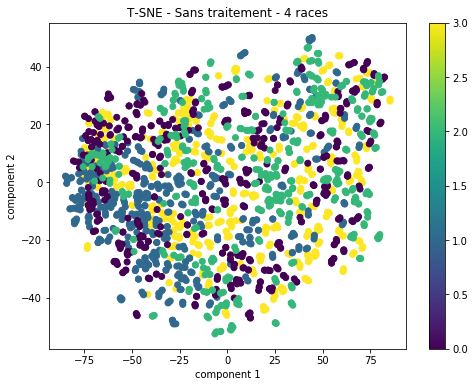

In [85]:
display_TSNE(tsne_results, y_train, 'T-SNE - Sans traitement - 4 races')

## 6.2 Avec égalisation histrogramme

In [87]:
prep_img = preprocess_images(x_train_img, ['EqualizeHistogram'])

Image Preprocessing elapsed time : 79.01s.


In [89]:
x_train_features = extractFeatures(prep_img)
bovw = MyBagOfVisualWords(n_clusters, x_train_features)
x_train2 = bovw.getBagOfVisualWords(x_train_features)
scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train2)

SIFT Extraction elapsed time : 207.13s.
Vocabulary construction elapsed time : 60.23s.
BOVW elapsed time : 1.47s.


In [90]:
tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(x_train2)

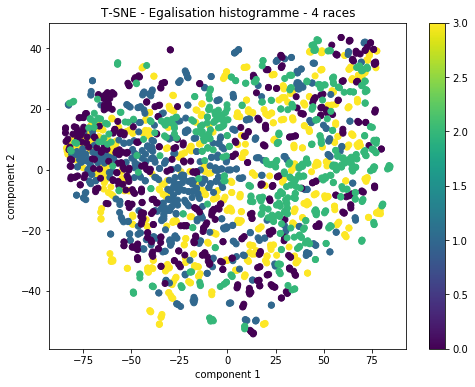

In [91]:
display_TSNE(tsne_results, y_train, 'T-SNE - Egalisation histogramme - 4 races')

## 6.3 Avec filtre gaussien

In [93]:
prep_img = preprocess_images(x_train_img, ['GaussianBlur'])

Image Preprocessing elapsed time : 96.43s.


In [94]:
x_train_features = extractFeatures(prep_img)
bovw = MyBagOfVisualWords(n_clusters, x_train_features)
x_train3 = bovw.getBagOfVisualWords(x_train_features)
scaler = StandardScaler()
x_train3 = scaler.fit_transform(x_train3)

SIFT Extraction elapsed time : 154.84s.
Vocabulary construction elapsed time : 10.11s.
BOVW elapsed time : 1.09s.


In [95]:
tsne = TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(x_train3)

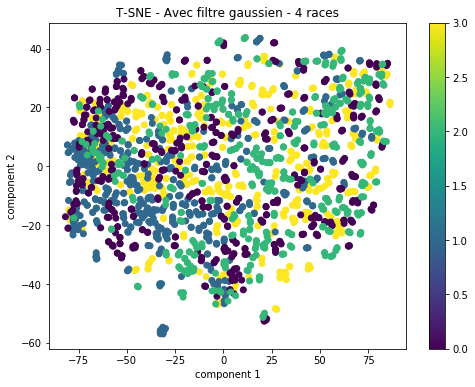

In [96]:
display_TSNE(tsne_results, y_train, 'T-SNE - Avec filtre gaussien - 4 races')